In [1]:
%load_ext lab_black

In [2]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as sts
import seaborn as sns

from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from venn import venn
import numpy as np

from IPython.display import display
import scipy.stats as sts
import itertools

In [3]:
epic = pd.read_csv(
    "../data/Additional/EPIC/MethylationEPIC_v-1-0_B4.csv",
    index_col=0,
    low_memory=False,
)

In [33]:
dmg = pd.read_csv("../DMGCoV_vs_nonCoVCorrectedTSS.csv", index_col=0).UCSC_RefGene_Name
dmg = dmg.str.split(";").explode().to_frame()

# Add PARP9 (the same probes as DTX3L)
parp9_probes = dmg[dmg["UCSC_RefGene_Name"] == "DTX3L"]
parp9_probes["UCSC_RefGene_Name"] = "PARP9"
dmg = pd.concat((dmg, parp9_probes))

display(dmg)
genes_set = set(dmg.UCSC_RefGene_Name.unique())

print(f"DMPs: {len(set(dmg.index))}")
print(f"Genes: {dmg.UCSC_RefGene_Name.nunique()}")

<ipython-input-33-ca62316f8224>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,UCSC_RefGene_Name
CpG,
cg15528722,TTC33
cg24678928,DDX60
cg03607951,IFI44L
cg07815522,DTX3L
cg24103563,TRIM34
cg13304609,IFI44L
cg15452182,LOC101928650
cg17515347,AIM2
cg07863524,OR3A4


DMPs: 26
Genes: 20


In [34]:
raw_ttable = pd.read_table("../Expression/GSE157103_genes.tpm.tsv", index_col=0).T
raw_ttable

#symbol,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
C1,0.49,0.00,0.21,0.04,0.07,0.0,0.03,18.92,4.07,0.0,...,2.84,4.22,0.95,1.63,15.51,0.06,8.17,363.01,19.17,6.05
C2,0.29,0.00,0.14,0.00,0.00,0.0,0.05,18.68,3.00,0.0,...,3.55,12.15,0.60,1.15,15.62,0.14,8.20,399.80,15.72,4.12
C3,0.26,0.00,0.03,0.02,0.00,0.0,0.07,13.85,1.83,0.0,...,1.34,2.79,0.18,0.32,17.67,0.28,3.62,430.35,13.95,1.81
C4,0.45,0.01,0.09,0.07,0.00,0.0,0.00,22.11,4.22,0.0,...,3.71,5.87,1.40,2.21,15.61,0.27,7.88,209.25,14.78,7.15
C5,0.17,0.00,0.00,0.05,0.07,0.0,0.00,8.45,1.17,0.0,...,1.44,4.46,0.28,0.55,9.34,0.07,5.96,272.91,8.69,2.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC22,0.30,0.00,0.02,0.02,0.00,0.0,0.00,17.06,1.96,0.0,...,0.26,1.01,0.13,0.46,5.93,0.24,1.58,447.14,3.04,1.00
NC23,0.70,0.00,0.02,0.01,0.00,0.0,0.00,20.31,1.54,0.0,...,0.64,0.83,0.18,0.73,8.75,0.12,1.57,748.55,4.55,1.56
NC24,0.75,0.00,0.27,0.00,0.06,0.0,0.00,27.25,3.42,0.0,...,1.18,2.14,0.41,1.29,14.93,0.14,5.05,437.62,10.34,3.99
NC25,2.80,0.00,0.04,0.00,0.00,0.0,0.00,21.64,1.43,0.0,...,0.42,0.61,0.19,0.45,4.77,0.33,1.07,369.66,1.83,0.96


In [35]:
raw_ttable = raw_ttable.loc[
    :, raw_ttable.mean().round(0) > 1
]  # Drop genes with average expression value > 1
raw_ttable.shape

(126, 10249)

#### Select differential methylated genes from *ttable*

In [36]:
ttable = raw_ttable[genes_set.intersection(set(raw_ttable.columns))]

genes_set = set(ttable.columns)  # Update genes
print("Updated number of genes: ", len(genes_set))


ttable["TYPE"] = [
    "Covid-19" if name.startswith("C") else "Non Covid-19" for name in raw_ttable.index
]  # Add TYPE column with disease status

ttable

Updated number of genes:  13


<ipython-input-36-377341e9b68f>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#symbol,PARP9,IFI44L,TRIM34,DDX60,AIM2,TRA2B,RSAD2,CRNKL1,DTX3L,MX1,TTC33,TRIM22,PGBD3,TYPE
C1,402.93,470.26,52.94,115.76,102.60,33.01,812.32,19.21,145.23,968.53,6.41,878.28,1.40,Covid-19
C2,112.39,10.81,24.57,15.15,36.29,40.79,28.71,15.67,39.90,53.01,5.82,236.38,1.60,Covid-19
C3,431.47,355.75,34.64,105.36,157.94,16.20,797.39,18.24,122.19,861.15,3.44,802.34,1.85,Covid-19
C4,100.88,17.33,29.81,13.57,16.85,49.26,20.48,21.55,40.19,101.72,6.32,224.91,2.43,Covid-19
C5,398.58,44.53,35.90,43.04,279.70,26.13,168.49,19.54,95.64,59.63,5.72,1086.22,1.63,Covid-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NC22,13.07,1.19,5.28,1.07,5.84,17.96,1.38,6.00,7.99,11.96,1.06,24.43,0.74,Non Covid-19
NC23,82.05,15.65,14.21,9.00,61.93,19.59,45.93,10.02,23.73,117.19,1.36,134.13,0.84,Non Covid-19
NC24,62.55,4.96,19.71,5.33,15.15,40.09,7.30,14.85,24.23,48.53,3.78,86.22,2.60,Non Covid-19
NC25,15.18,17.61,5.08,2.72,4.67,16.58,50.27,9.21,14.29,101.83,0.86,35.02,0.64,Non Covid-19


<Figure size 936x936 with 0 Axes>

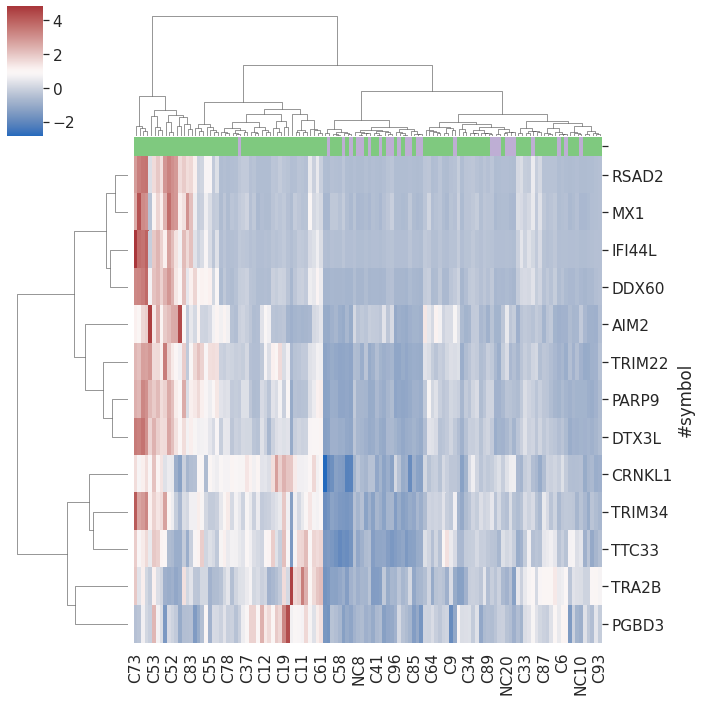

In [37]:
pal = sns.color_palette("Accent", ttable["TYPE"].nunique())
lut = dict(zip(map(str, ttable["TYPE"].unique()), pal))
colors = ttable["TYPE"].map(lut)
colors.name = ""

sns.set(font_scale=1.4)
plt.figure(figsize=(13, 13))

df_ttable = ttable.drop("TYPE", axis=1)

cols = df_ttable.columns
idx = df_ttable.index

df_ttable = StandardScaler().fit_transform(df_ttable)
df_ttable = pd.DataFrame(df_ttable, index=idx, columns=cols).T

fig = sns.clustermap(df_ttable, method="ward", col_colors=colors, cmap="vlag")
fig.savefig("../Plots/CLS_expression_with_PARP9.jpg")
plt.show()

#### Looking for DEGs adjusted for cell fractions
##### Step 1: Prepare cell fractions data

In [38]:
cf = pd.read_csv(
    "../data/processed/CF/USA_before_CFC.csv", index_col=0
)  # -> Estimated WBC for each sample

sample_names = dict(
    pd.read_csv("../data/raw/CONCATED_USA_HB/SampleSheet.csv", index_col=0)["ID"]
)

cf.index = [
    sample_names.get(name) if name in sample_names.keys() else name for name in cf.index
]  # Convert GSE to IDs

ins = set.intersection(
    set(ttable.index), set(cf.index)
)  # select common samples for methylation data [predicted cell fractions] and expression data

cf = cf.loc[ins]
ttable = ttable.loc[ins]

cf = pd.concat(
    (cf, ttable["TYPE"].map({"Covid-19": 1, "Non Covid-19": 0})), axis=1
).dropna()  # Merge predicted cell fractions and disease status [TYPE]

cf.drop("Eosino", axis=1, inplace=True)  # Drop Eosino fraction due to low abudance

#### Step 2: Find DEGs

                            OLS Regression Results                            
Dep. Variable:                  PARP9   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     4.053
Date:                Tue, 10 Aug 2021   Prob (F-statistic):           0.000991
Time:                        15:11:48   Log-Likelihood:                -756.93
No. Observations:                 125   AIC:                             1528.
Df Residuals:                     118   BIC:                             1548.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B           -862.6196    739.077     -1.167      0.2

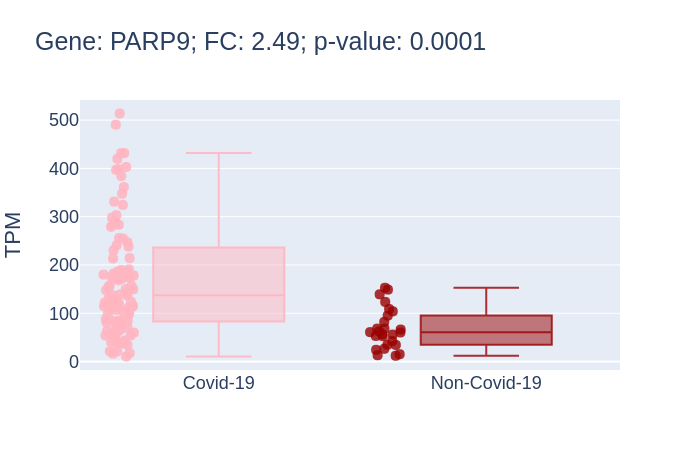

                            OLS Regression Results                            
Dep. Variable:                  PGBD3   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     2.647
Date:                Tue, 10 Aug 2021   Prob (F-statistic):             0.0191
Time:                        15:11:48   Log-Likelihood:                -143.50
No. Observations:                 125   AIC:                             301.0
Df Residuals:                     118   BIC:                             320.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B              1.0596      5.463      0.194      0.8

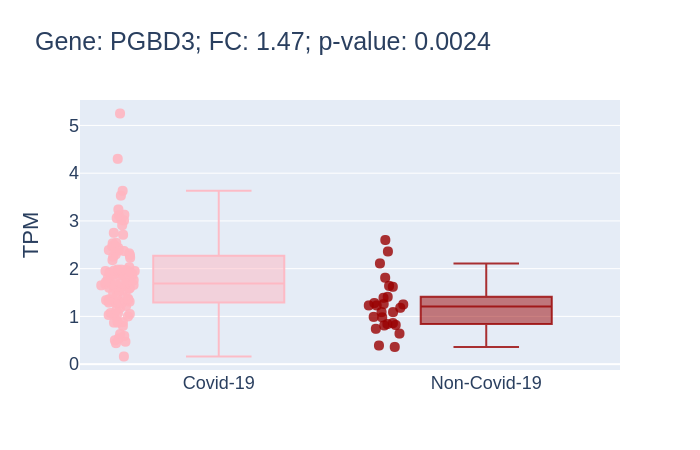

                            OLS Regression Results                            
Dep. Variable:                 IFI44L   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     4.862
Date:                Tue, 10 Aug 2021   Prob (F-statistic):           0.000180
Time:                        15:11:48   Log-Likelihood:                -752.19
No. Observations:                 125   AIC:                             1518.
Df Residuals:                     118   BIC:                             1538.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B           -993.5239    711.558     -1.396      0.1

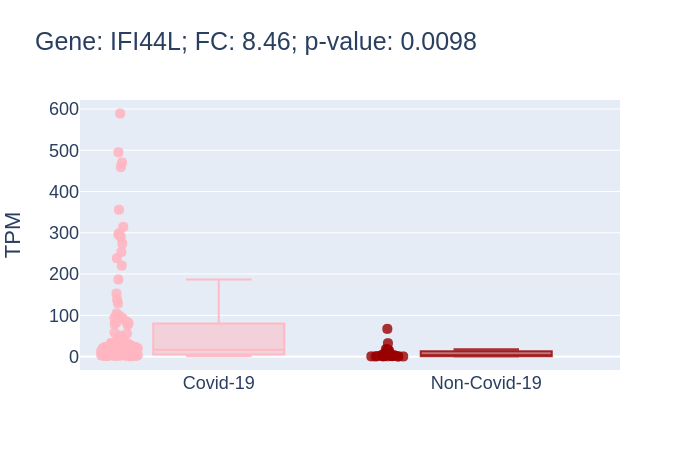

                            OLS Regression Results                            
Dep. Variable:                 TRIM34   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     3.894
Date:                Tue, 10 Aug 2021   Prob (F-statistic):            0.00139
Time:                        15:11:48   Log-Likelihood:                -471.80
No. Observations:                 125   AIC:                             957.6
Df Residuals:                     118   BIC:                             977.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B            -68.2032     75.512     -0.903      0.3

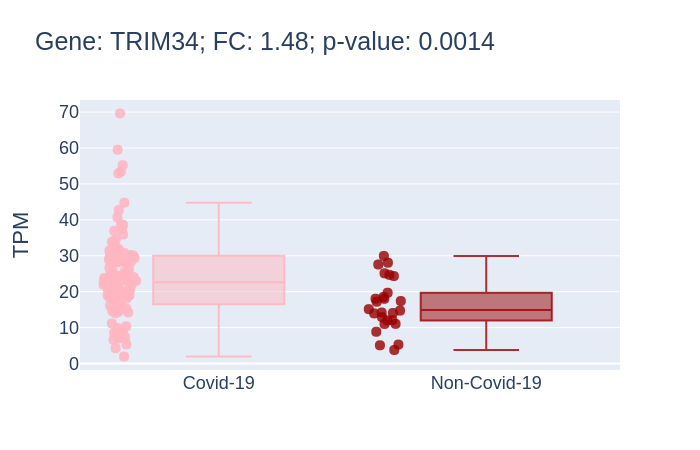

                            OLS Regression Results                            
Dep. Variable:                   AIM2   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     3.138
Date:                Tue, 10 Aug 2021   Prob (F-statistic):            0.00686
Time:                        15:11:48   Log-Likelihood:                -653.59
No. Observations:                 125   AIC:                             1321.
Df Residuals:                     118   BIC:                             1341.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B           -259.3629    323.323     -0.802      0.4

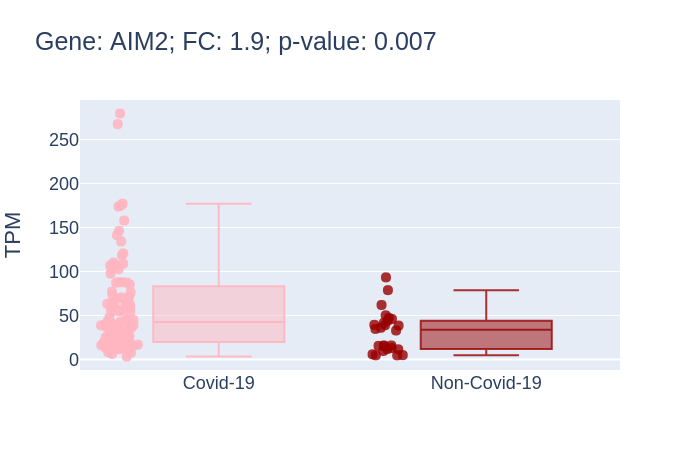

                            OLS Regression Results                            
Dep. Variable:                  DDX60   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     2.962
Date:                Tue, 10 Aug 2021   Prob (F-statistic):            0.00993
Time:                        15:11:48   Log-Likelihood:                -588.65
No. Observations:                 125   AIC:                             1191.
Df Residuals:                     118   BIC:                             1211.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B           -187.4442    192.308     -0.975      0.3

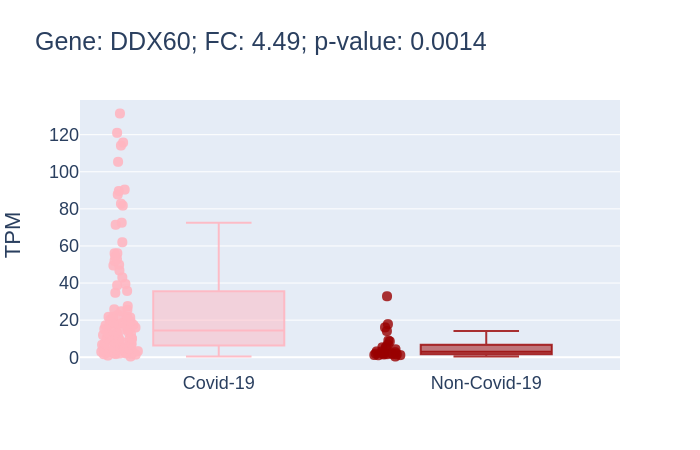

                            OLS Regression Results                            
Dep. Variable:                  RSAD2   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     2.552
Date:                Tue, 10 Aug 2021   Prob (F-statistic):             0.0233
Time:                        15:11:49   Log-Likelihood:                -836.16
No. Observations:                 125   AIC:                             1686.
Df Residuals:                     118   BIC:                             1706.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B          -1695.3429   1393.029     -1.217      0.2

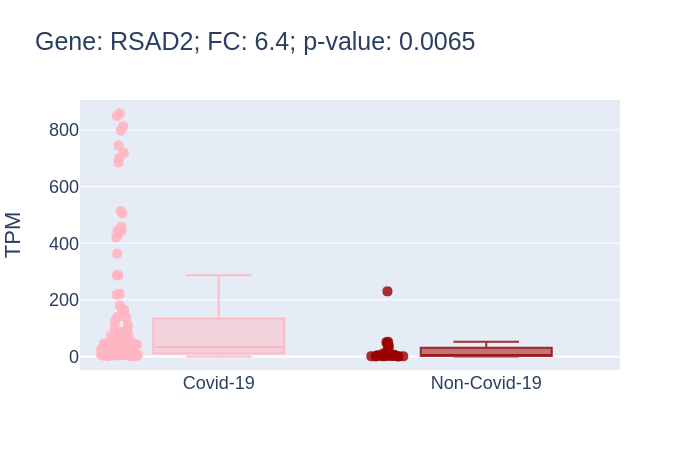

                            OLS Regression Results                            
Dep. Variable:                 CRNKL1   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.017
Date:                Tue, 10 Aug 2021   Prob (F-statistic):             0.0686
Time:                        15:11:49   Log-Likelihood:                -361.28
No. Observations:                 125   AIC:                             736.6
Df Residuals:                     118   BIC:                             756.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B            -13.6317     31.193     -0.437      0.6

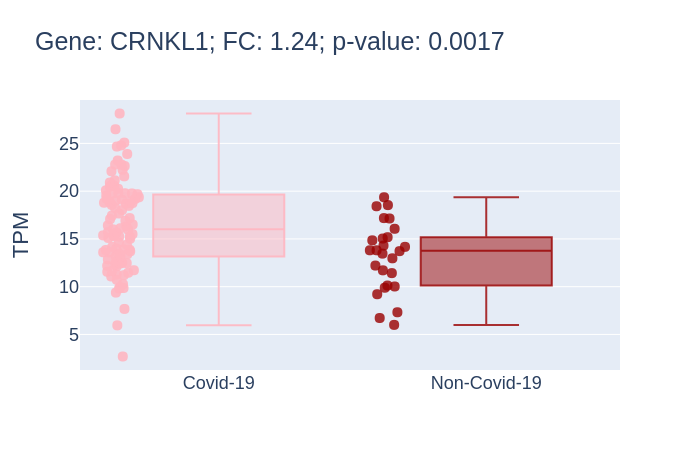

                            OLS Regression Results                            
Dep. Variable:                  DTX3L   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     5.069
Date:                Tue, 10 Aug 2021   Prob (F-statistic):           0.000116
Time:                        15:11:49   Log-Likelihood:                -591.16
No. Observations:                 125   AIC:                             1196.
Df Residuals:                     118   BIC:                             1216.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B           -255.9974    196.219     -1.305      0.1

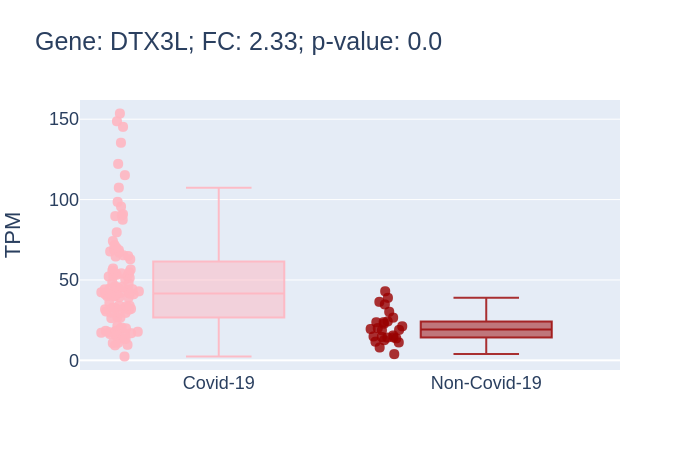

                            OLS Regression Results                            
Dep. Variable:                    MX1   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     3.497
Date:                Tue, 10 Aug 2021   Prob (F-statistic):            0.00322
Time:                        15:11:49   Log-Likelihood:                -826.07
No. Observations:                 125   AIC:                             1666.
Df Residuals:                     118   BIC:                             1686.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B          -1261.3157   1284.983     -0.982      0.3

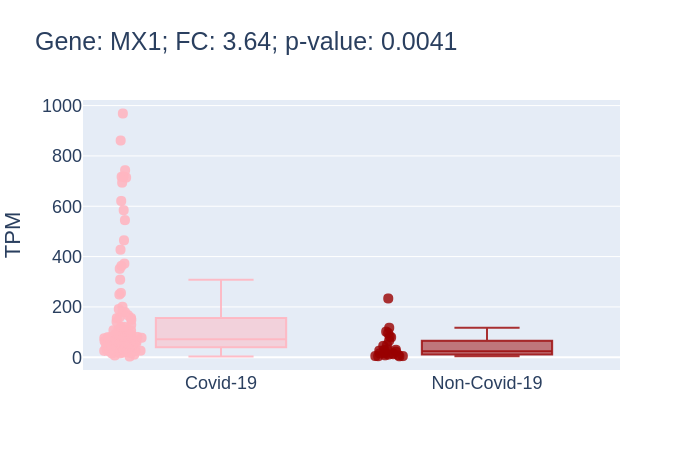

                            OLS Regression Results                            
Dep. Variable:                  TTC33   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     3.663
Date:                Tue, 10 Aug 2021   Prob (F-statistic):            0.00226
Time:                        15:11:49   Log-Likelihood:                -263.17
No. Observations:                 125   AIC:                             540.3
Df Residuals:                     118   BIC:                             560.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B             14.0966     14.229      0.991      0.3

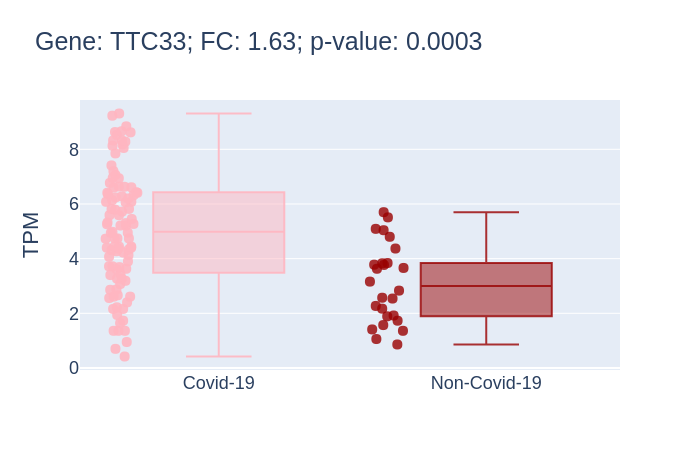

                            OLS Regression Results                            
Dep. Variable:                 TRIM22   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     3.799
Date:                Tue, 10 Aug 2021   Prob (F-statistic):            0.00170
Time:                        15:11:49   Log-Likelihood:                -862.78
No. Observations:                 125   AIC:                             1740.
Df Residuals:                     118   BIC:                             1759.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B          -1910.4366   1723.554     -1.108      0.2

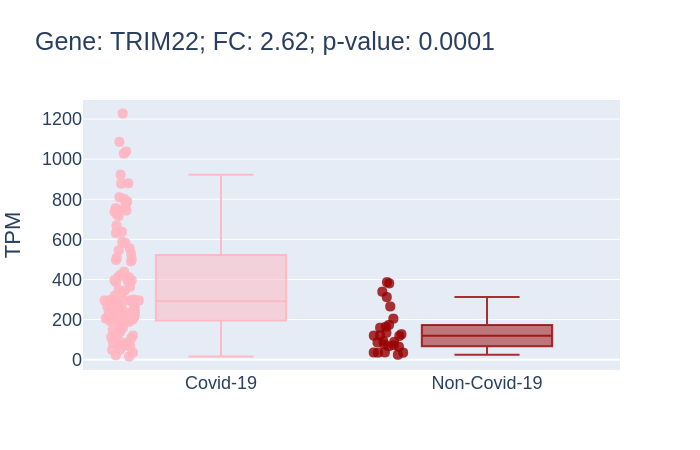

                            OLS Regression Results                            
Dep. Variable:                  TRA2B   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     10.25
Date:                Tue, 10 Aug 2021   Prob (F-statistic):           4.08e-09
Time:                        15:11:49   Log-Likelihood:                -469.74
No. Observations:                 125   AIC:                             953.5
Df Residuals:                     118   BIC:                             973.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B            106.5093     74.283      1.434      0.1

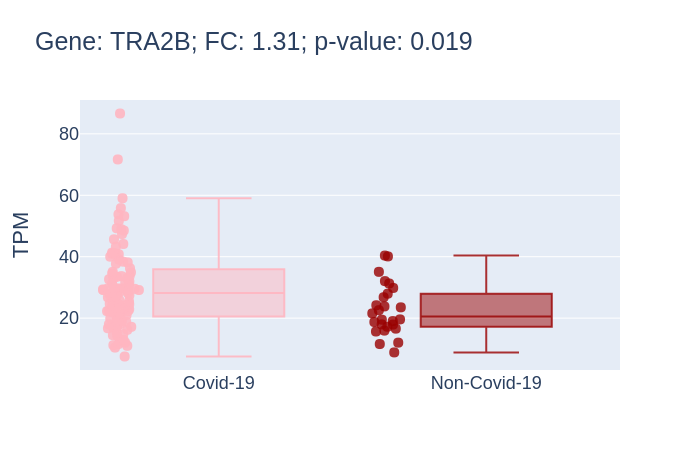

In [39]:
DEG = []

for common_gene in genes_set:

    df = pd.concat(
        (ttable[common_gene], cf), axis=1
    ).dropna()  # Merge expression data with CF

    mod = sm.OLS(df[common_gene], df.drop(common_gene, axis=1))  # Initialize model
    res = mod.fit()  # Fitting

    pvalues = res.pvalues
    pval = round(pvalues.TYPE, 4)  # pvalue for TYPE variable

    cov = ttable[ttable["TYPE"] == "Covid-19"][
        common_gene
    ].values.flatten()  # Expression for covid samples
    nocov = ttable[ttable["TYPE"] == "Non Covid-19"][
        common_gene
    ].values.flatten()  # Expression for non-covid samples

    fc = np.mean(cov) / np.mean(nocov)  # Fold change

    if ((fc >= 1.5) | (fc <= 0.5)) & (pval <= 0.05):
        DEG.append(common_gene)

    print(res.summary())
    fig = go.Figure()

    # Add covid expression box
    fig.add_trace(
        go.Box(
            x=["Covid-19"] * len(cov),
            y=cov,
            name="Covid-19",
            boxpoints="all",
            marker_color="rgba(255, 182, 193, .9)",
        )
    )

    # Add non-covid expression box
    fig.add_trace(
        go.Box(
            x=["Non-Covid-19"] * len(nocov),
            y=nocov,
            name="Non-Covid-19",
            boxpoints="all",
            marker_color="rgba(152, 0, 0, .8)",
        )
    )

    fig.update_layout(
        title=f"Gene: {common_gene}; FC: {round(fc, 2)}; p-value: {pval}",
        yaxis_title="TPM",
        showlegend=False,
    )

    fig.update_layout(legend=dict(font=dict(size=24), title=""), font=dict(size=18))
    fig.update_traces(marker=dict(size=10))

    fig.show(renderer="png")
    fig.write_image(f"../Plots/ExpressionBoxes/{common_gene}.jpg")

In [40]:
print(f"Number of DEGs: {len(DEG)}")
print(DEG)

pd.DataFrame(DEG).to_csv("../DEGs.csv")

Number of DEGs: 9
['PARP9', 'IFI44L', 'AIM2', 'DDX60', 'RSAD2', 'DTX3L', 'MX1', 'TTC33', 'TRIM22']


In [41]:
dmg

,UCSC_RefGene_Name
CpG,
cg15528722,TTC33
cg24678928,DDX60
cg03607951,IFI44L
cg07815522,DTX3L
cg24103563,TRIM34
cg13304609,IFI44L
cg15452182,LOC101928650
cg17515347,AIM2
cg07863524,OR3A4


#### Perform clustering using **DEGs**

<Figure size 936x936 with 0 Axes>

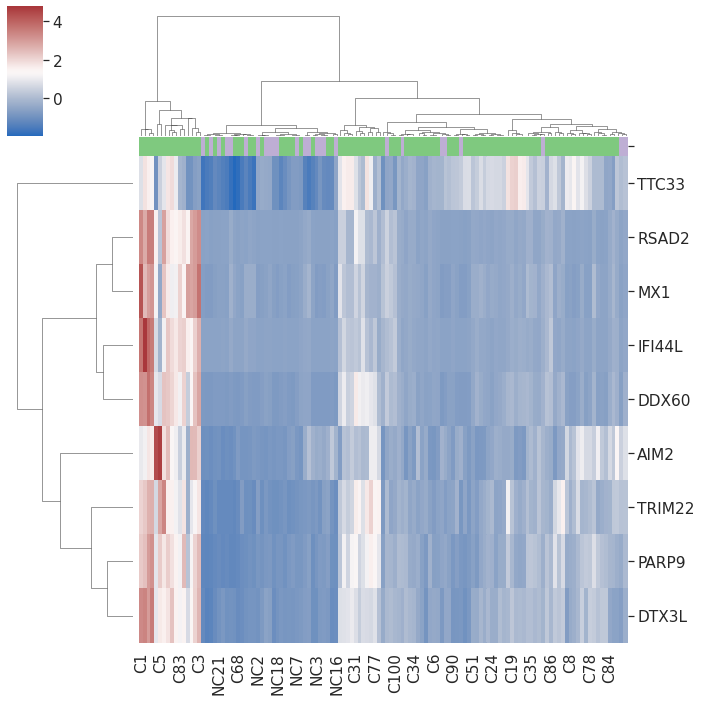

In [42]:
pal = sns.color_palette("Accent", ttable["TYPE"].nunique())
lut = dict(zip(map(str, ttable["TYPE"].unique()), pal))
colors = ttable["TYPE"].map(lut)
colors.name = ""

plt.figure(figsize=(13, 13))
sns.set(font_scale=1.4)

df_ttable = StandardScaler().fit_transform(ttable[DEG]).T
df_ttable = pd.DataFrame(df_ttable, index=DEG, columns=ttable.index)

fig = sns.clustermap(df_ttable, method="ward", col_colors=colors, cmap="vlag")
fig.savefig("../Plots/CLS_with_PARP9.jpg")
plt.show()

In [43]:
df_ttable = df_ttable.T
df_ttable

,PARP9,IFI44L,AIM2,DDX60,RSAD2,DTX3L,MX1,TTC33,TRIM22
C83,1.198045,2.088214,0.489997,1.178873,1.658022,1.212197,2.110907,-0.087292,0.867749
C26,0.877454,-0.419473,-0.736736,-0.345097,-0.392571,0.354222,-0.454647,0.832403,0.648689
NC14,-0.462095,-0.520693,-0.152891,-0.710725,-0.549353,-0.745261,-0.662352,-0.119644,-0.465783
C80,1.240050,1.461608,2.545386,1.385125,2.834101,1.467050,2.875986,-0.909934,0.966892
NC10,-0.763891,-0.519431,-0.190950,-0.658989,-0.547612,-0.763488,-0.648022,0.407217,-0.793687
...,...,...,...,...,...,...,...,...,...
NC18,-0.833692,-0.516366,-0.770680,-0.713503,-0.546451,-0.876756,-0.631587,-0.965393,-0.951952
C28,0.729733,-0.317352,-0.346271,-0.007247,-0.180595,0.381563,-0.310732,-0.105779,1.580396
NC3,-0.837398,-0.522135,-0.297515,-0.708989,-0.549450,-0.971472,-0.663636,-1.136392,-0.760931
C64,0.079990,-0.479682,0.152609,-0.595099,-0.522360,0.317768,-0.497225,-0.433911,-0.157053


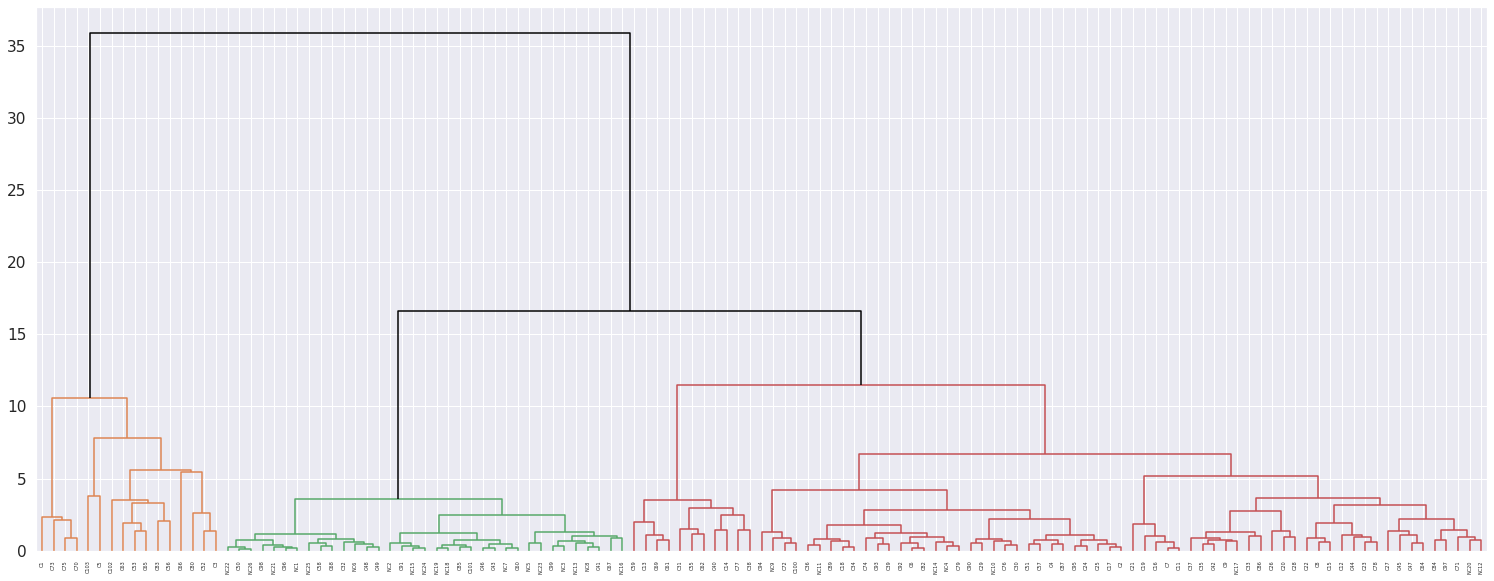

In [44]:
fig = plt.figure(figsize=(26, 10))

Z = linkage(df_ttable, "ward")
dn = dendrogram(
    Z,
    labels=df_ttable.index,
    color_threshold=12,
    above_threshold_color="00000",
    truncate_mode=None,
)

plt.show()
fig.savefig("../Plots/DendrogramCoVNonCoVUSA_with_PARP9.jpg")

In [45]:
# Annotate samples to clusters

In [46]:
cls_ = fcluster(Z, t=12, criterion="distance")
cls_ = pd.DataFrame(cls_, index=df_ttable.index, columns=["Clusters"])
cls_

,Clusters
C83,1
C26,3
NC14,3
C80,1
NC10,3
...,...
NC18,2
C28,3
NC3,2
C64,3


In [47]:
# Load data about samples from: https://doi.org/10.1186/s13148-021-01102-9

In [48]:
usa_poi = pd.read_csv("../data/raw/Annotations/Clinical_GSE174818.csv", index_col=0)
usa_poi = pd.concat((cls_, usa_poi), axis=1)
usa_poi

,Clusters,Covid (1=yes),Diagnosis,ICU (1=yes),Sex,Age,Ethnicity,BMI,WHO ordinal at day 28,Charlson,...,Rheumatic disease,PUD,Liver disese,DM,Hemiplegia,Renal disease,Cancer (solid),HIV/AIDS,Leukemia/lymphoma,Smoking 1=y (current or former);0=never;?=unknown
C83,1.0,1,COVID-19,0,F,85,W,31.07,4,5,...,0,0,0,0,0,0,0,0,0,0
C26,3.0,1,COVID-19,1,F,41,H,44.60,0,2,...,0,0,0,0,0,0,0,0,0,0
NC14,3.0,0,COPD exacerbation,1,F,75,W,30.79,0,5,...,0,0,0,0,0,0,0,0,0,1
C80,1.0,1,COVID-19,1,M,71,W,34.60,8,7,...,0,0,0,0,0,0,1,0,0,0
NC10,3.0,0,sepsis,1,M,67,W,38.50,0,3,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C64,3.0,1,COVID-19,1,M,65,O,29.30,6,2,...,0,0,0,0,0,0,0,0,0,0
NC24,2.0,0,pneumonia,0,F,32,W,18.50,0,0,...,0,0,0,0,0,0,0,0,0,0
C10,NaN,1,COVID-19,1,M,62,A,24.50,6,1,...,0,0,0,0,0,0,0,0,0,0
C81,NaN,1,COVID-19,1,M,74,AA,30.70,8,6,...,0,0,0,0,0,1,0,0,0,0


#### Test clusters against clinical data

In [49]:
for column in usa_poi.columns:
    if column == "Clusters":
        continue
    try:
        df = pd.crosstab(usa_poi["Clusters"], usa_poi[column])
        _, pval, dof, _ = sts.chi2_contingency(df)
        if pval <= 0.05 and dof <= 4:
            print(f"Column: {column}, p-value: {pval}")
            display(df)
            df["Sum"] = df.sum(axis=1)
            df.iloc[:, :2] = df.div(df["Sum"], axis=0)
            display(df.round(2))
            print("-" * 100)
    except Exception as e:
        print(f"Error: {e} for column: {column}")

Column: Covid (1=yes), p-value: 6.112472422864565e-07


Covid (1=yes),0,1
Clusters,,
1.0,0,16
2.0,18,17
3.0,8,66


Covid (1=yes),0,1,Sum
Clusters,,,
1.0,0.00,1.00,16
2.0,0.51,0.49,35
3.0,0.11,0.89,74


----------------------------------------------------------------------------------------------------
Column: ICU (1=yes), p-value: 0.0016916922608405764


ICU (1=yes),0,1
Clusters,,
1.0,14,2
2.0,12,23
3.0,34,40


ICU (1=yes),0,1,Sum
Clusters,,,
1.0,0.88,0.12,16
2.0,0.34,0.66,35
3.0,0.46,0.54,74


----------------------------------------------------------------------------------------------------
Column: Hydroxychloriquin, p-value: 0.0023058682160839394


Hydroxychloriquin,0,1
Clusters,,
1.0,2,14
2.0,19,16
3.0,19,55


Hydroxychloriquin,0,1,Sum
Clusters,,,
1.0,0.12,0.88,16
2.0,0.54,0.46,35
3.0,0.26,0.74,74


----------------------------------------------------------------------------------------------------
Column: Antibiotics, p-value: 0.0011195429242436541


Antibiotics,0,1
Clusters,,
1.0,2,14
2.0,9,26
3.0,2,72


Antibiotics,0,1,Sum
Clusters,,,
1.0,0.12,0.88,16
2.0,0.26,0.74,35
3.0,0.03,0.97,74


----------------------------------------------------------------------------------------------------
